In [3]:
# Import `numpy` under the alias `np`
import numpy as np 

# Import `pandas` under the alias `pd`
import pandas as pd 
import pmdarima as pm

import itertools #to iterate through the loops

import statsmodels.api as sm

import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

import plotly.express as px
import plotly.offline as py

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import Series

from datetime import datetime
from matplotlib import pyplot


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

#FBProphet related imports
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Importing the Auto-Arima function 
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error

 # to split the data into train and test parts
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score 


def p_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reading the data from a file

In [4]:
df = pd.read_excel('Sales_Forecast_Data-Original.xlsx')

In [5]:
df.head() # returns top n (5 by default) rows of a data frame

FIN_YEAR MONTH    STATE            FG DISTRICT  COMPANY    VALUE
0  2014-2015   Nov  Haryana  Insecticides   Rohtak  monous    675.00
1  2014-2015   Nov  Haryana  Insecticides   Rewari  monous     73.71
2  2014-2015   Nov  Haryana  Insecticides  Gurgaon  monous    405.00
3  2014-2015   Nov  Haryana  Insecticides    Mewat  monous   1188.00
4  2014-2015   Nov  Haryana  Insecticides   Palwal  monous   5188.59

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230152 entries, 0 to 230151
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FIN_YEAR  230152 non-null  object 
 1   MONTH     230152 non-null  object 
 2   STATE     230152 non-null  object 
 3   FG        230152 non-null  object 
 4   DISTRICT  230152 non-null  object 
 5   COMPANY   230152 non-null  object 
 6   VALUE     230152 non-null  float64
dtypes: float64(1), object(6)
memory usage: 12.3+ MB


# Data Preparation for modelling : using ABC Manufacturing data only

In [7]:
#Constants used within this file
train_start_date = '2014-01-01'
train_end_date = '2017-06-01'
test_start_date = '2017-07-01'
test_end_date = '2017-12-01'
consider_rolling_window = True
consider_mean_values = False
predict_periods=6
missing_record_index = 37

In [8]:
if consider_rolling_window == True:
    rolling_period = 5
else:
    #do not change this value
    rolling_period = 1     

In [9]:
#Creating a dataframe of ABC manufacturing
ABC_df = df.loc[df['COMPANY'] == 'ABC Manufacturing']

In [10]:
#converting year range to year  . for example  "2014-2015"  will be converted to 2014 
ABC_df['FIN_YEAR'] = ABC_df.FIN_YEAR.str.slice(0,4)

#converting month to datetime for checking stationarity  
ABC_df['MONTH'] = pd.to_datetime(ABC_df['FIN_YEAR'].astype(str)+ "-"+ ABC_df['MONTH'].astype(str) + "-1")

In [11]:
ABC_df.isnull().sum() #Checking the null values in the ABC manufacturing company

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [12]:
ABC_df.isna().sum() 

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [13]:
#Considering only Himachal Pradesh data for ABC manufacturing company only
ABC_df = ABC_df.loc[ (ABC_df['STATE'] == 'Himachal Pradesh')]
ABC_df

FIN_YEAR      MONTH             STATE            FG  DISTRICT  \
141        2014 2014-07-01  Himachal Pradesh  Insecticides    Kangra   
142        2014 2014-07-01  Himachal Pradesh  Insecticides     Kullu   
143        2014 2014-07-01  Himachal Pradesh  Insecticides     Mandi   
144        2014 2014-07-01  Himachal Pradesh  Insecticides  Hamirpur   
145        2014 2014-07-01  Himachal Pradesh  Insecticides  Bilaspur   
...         ...        ...               ...           ...       ...   
229553     2016 2016-12-01  Himachal Pradesh  Bactericides    Shimla   
229877     2016 2016-10-01  Himachal Pradesh  Bactericides  Hamirpur   
229878     2016 2016-10-01  Himachal Pradesh  Bactericides    Kangra   
229879     2016 2016-10-01  Himachal Pradesh  Bactericides    Kangra   
229882     2016 2016-10-01  Himachal Pradesh  Bactericides     Mandi   

                  COMPANY     VALUE  
141     ABC Manufacturing  3075.300  
142     ABC Manufacturing    89.100  
143     ABC Manufacturing  1561.005  
144     ABC Manufacturing   133.650  
145     ABC Manufacturing  2568.915  
...                   ...       ...  
229553  ABC Manufacturing     0.000  
229877  ABC Manufacturing     0.000  
229878  ABC Manufacturing     0.000  
229879  ABC Manufacturing     0.000  
229882  ABC Manufacturing     0.000  

[3880 rows x 7 columns]

In [14]:
ABC_df.describe()

VALUE
count  3880.000000
mean    158.685646
std     507.967772
min       0.000000
25%       0.000000
50%       0.000000
75%      67.500000
max    6709.500000

In [15]:
ABC_df_Pesticides = ABC_df.copy(deep=True)
ABC_df_Pesticides.drop(['FIN_YEAR', 'STATE', 'FG', 'DISTRICT', 'COMPANY'],axis=1,inplace = True)

In [16]:
# Upon inspection it is found that for a period of Feb and March in 2017, there was no data. 
# We need to treat this data else seasonal_decompose() will throw error

In [17]:
# SUM 

if consider_mean_values == False:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].sum().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':12270.105}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':13035.15}
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])                                 

In [18]:
# MEAN 

if consider_mean_values == True:
    ABC_df_Pesticides = ABC_df_Pesticides.groupby('MONTH')['VALUE'].mean().reset_index()
    
    df1 = ABC_df_Pesticides[: missing_record_index]
    df2 = ABC_df_Pesticides[missing_record_index:]

    new_row = {'MONTH': datetime.strptime('2017-02-01', '%Y-%m-%d').date(), 'VALUE':196}
    df1.loc[missing_record_index] = new_row

    new_row = {'MONTH': datetime.strptime('2017-03-01', '%Y-%m-%d').date(), 'VALUE':218}
    df1.loc[missing_record_index + 1] = new_row
                        
    ABC_df_Pesticides = pd.concat([df1, df2])
    

In [19]:
ABC_df_Pesticides

MONTH      VALUE
0   2014-01-01 00:00:00  21497.670
1   2014-02-01 00:00:00  12344.535
2   2014-03-01 00:00:00   2396.790
3   2014-04-01 00:00:00   6969.780
4   2014-05-01 00:00:00  10023.480
5   2014-06-01 00:00:00  18159.390
6   2014-07-01 00:00:00  14409.630
7   2014-08-01 00:00:00   7495.875
8   2014-09-01 00:00:00    165.375
9   2014-10-01 00:00:00  13826.835
10  2014-11-01 00:00:00  24801.930
11  2014-12-01 00:00:00  16783.740
12  2015-01-01 00:00:00  15356.250
13  2015-02-01 00:00:00   8318.295
14  2015-03-01 00:00:00  21547.080
15  2015-04-01 00:00:00  16622.820
16  2015-05-01 00:00:00   7457.400
17  2015-06-01 00:00:00  21232.530
18  2015-07-01 00:00:00  14526.675
19  2015-08-01 00:00:00  14110.470
20  2015-09-01 00:00:00  16156.800
21  2015-10-01 00:00:00  21325.950
22  2015-11-01 00:00:00  14076.855
23  2015-12-01 00:00:00  16709.220
24  2016-01-01 00:00:00   7311.870
25  2016-02-01 00:00:00  16147.485
26  2016-03-01 00:00:00  15161.580
27  2016-04-01 00:00:00   1407.780
28  2016-05-01 00:00:00  15280.110
29  2016-06-01 00:00:00  15497.595
30  2016-07-01 00:00:00  14288.805
31  2016-08-01 00:00:00   7198.335
32  2016-09-01 00:00:00  24069.150
33  2016-10-01 00:00:00  18596.250
34  2016-11-01 00:00:00  13007.385
35  2016-12-01 00:00:00  11162.610
36  2017-01-01 00:00:00  15490.440
37           2017-02-01  12270.105
38           2017-03-01  13035.150
37  2017-04-01 00:00:00   7897.095
38  2017-05-01 00:00:00  10102.455
39  2017-06-01 00:00:00   6543.450
40  2017-07-01 00:00:00  17274.870
41  2017-08-01 00:00:00   2613.465
42  2017-09-01 00:00:00  11216.475
43  2017-10-01 00:00:00    512.595
44  2017-11-01 00:00:00  26836.380
45  2017-12-01 00:00:00  21768.750

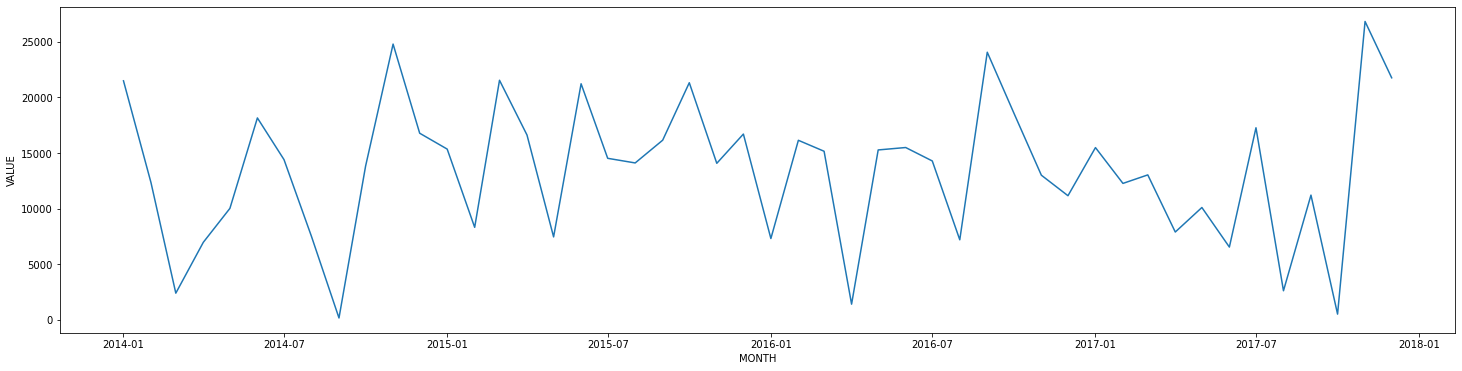

In [20]:
#Plot the data 
plt.figure(figsize=(25,6))
sns.lineplot(x="MONTH", y="VALUE", data=ABC_df_Pesticides,  ci= None)

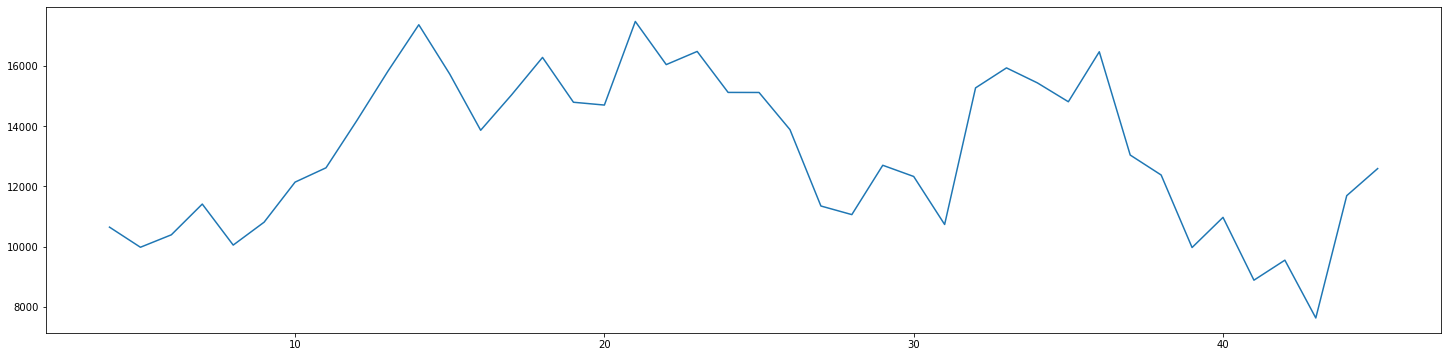

In [21]:
if consider_rolling_window == True:
    xyzseries = ABC_df_Pesticides['VALUE'].rolling(window = rolling_period)
    XYZmean = xyzseries.mean()
    plt.figure(figsize=(25,6))
    sns.lineplot( data=XYZmean,  ci= None)
    

[Text(0, 0, 'VALUE')]

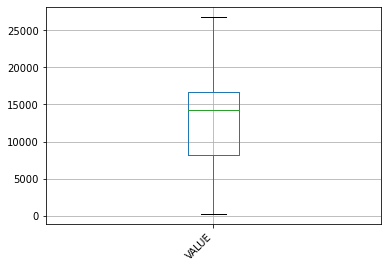

In [22]:
boxplot = ABC_df_Pesticides.boxplot(column=['VALUE'])
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45, horizontalalignment='right')

In [23]:
ABC_df_Pesticides.describe()

VALUE
count     48.000000
mean   13354.282500
std     6414.494717
min      165.375000
25%     8212.995000
50%    14199.637500
75%    16727.850000
max    26836.380000

In [24]:
print(ABC_df_Pesticides["VALUE"].quantile(0.95))

23264.010000000002


In [25]:
#ABC_df_Pesticides["VALUE"]=np.where(ABC_df_Pesticides["VALUE"]>66082.66875,66082.66875,ABC_df_Pesticides["VALUE"])

In [26]:
if consider_rolling_window == True:
    ABC_df_Pesticides['VALUE'] = XYZmean
    ABC_df_Pesticides = ABC_df_Pesticides[rolling_period - 1:]


# Check for Stationarity and Seasonality

In [27]:
# for a time series to be Sationary
# 1. Mean has to be constant 
# 2. variance has to be constant 
# 3. No seasonality

# If a timeseries has seasonality, then it is not stationary. i.e ARMA models cannot be run.

In [28]:
# Augmented Dickey FULLER test to check Stationarity

def ADF_test(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [29]:
ADF_test(ABC_df_Pesticides['VALUE'])

Test statistic = -3.815
P-value = 0.003
Critical values :
	1%: -3.610399601308181 - The data is  stationary with 99% confidence
	5%: -2.939108945868946 - The data is  stationary with 95% confidence
	10%: -2.6080629651545038 - The data is  stationary with 90% confidence


In [30]:
# from the above result, as p-value < 0.05... we can conclude that the timeseries data is Stationary

In [31]:
# Additional check using KPSS method   [ Kwiatkowski–Phillips–Schmidt–Shin (KPSS)]
# Ref: https://www.statisticshowto.com/kpss-test/

stats, p, lags, critical_values = kpss(ABC_df_Pesticides['VALUE'],'c')
stats, p, lags, critical_values

print(f'Test Statistics: {stats}')
print(f'p value: {p}')
print(f'critical_values: {critical_values}')



Test Statistics: 0.16941527598278022
p value: 0.1
critical_values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [32]:
# as 0.1  is greater than 0.05, we can conclude that the timeseries data is Stationary

In [33]:
ABC_df_Pesticides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 4 to 45
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MONTH   44 non-null     object 
 1   VALUE   44 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [34]:
# Reset index after converting 'Month' to Datetime
ABC_df_Pesticides['MONTH'] = pd.to_datetime(ABC_df_Pesticides['MONTH'])
ABC_df_Pesticides.set_index('MONTH', inplace=True)

In [35]:
ABC_df_Pesticides

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

<Figure size 2160x2520 with 0 Axes>

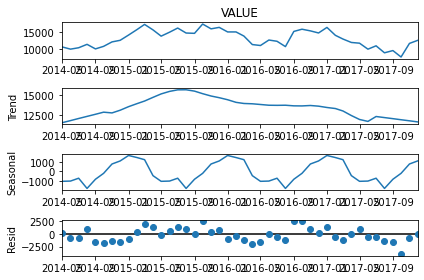

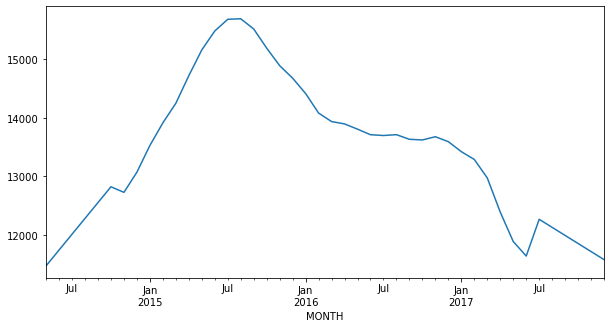

In [36]:
res = sm.tsa.seasonal_decompose(ABC_df_Pesticides['VALUE'],model = 'additive',extrapolate_trend='freq')

plt.figure(figsize=(30,35))
resplot = res.plot(observed=True)

plt.figure(figsize=(10, 5))
res.trend.plot()

# FBProphet Model

In [37]:
ABC_df_Pesticides_FBP =  ABC_df_Pesticides.copy(deep=True)

In [38]:
ABC_df_Pesticides_FBP = ABC_df_Pesticides_FBP.reset_index()[['MONTH','VALUE']].rename({'MONTH':'ds','VALUE':'y'}, axis='columns')

In [39]:
train = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] <= pd.to_datetime(train_end_date)]
train

ds          y
0  2014-05-01  10646.451
1  2014-06-01   9978.795
2  2014-07-01  10391.814
3  2014-08-01  11411.631
4  2014-09-01  10050.750
5  2014-10-01  10811.421
6  2014-11-01  12139.929
7  2014-12-01  12614.751
8  2015-01-01  14186.826
9  2015-02-01  15817.410
10 2015-03-01  17361.459
11 2015-04-01  15725.637
12 2015-05-01  13860.369
13 2015-06-01  15035.625
14 2015-07-01  16277.301
15 2015-08-01  14789.979
16 2015-09-01  14696.775
17 2015-10-01  17470.485
18 2015-11-01  16039.350
19 2015-12-01  16475.859
20 2016-01-01  15116.139
21 2016-02-01  15114.276
22 2016-03-01  13881.402
23 2016-04-01  11347.587
24 2016-05-01  11061.765
25 2016-06-01  12698.910
26 2016-07-01  12327.174
27 2016-08-01  10734.525
28 2016-09-01  15266.799
29 2016-10-01  15930.027
30 2016-11-01  15431.985
31 2016-12-01  14806.746
32 2017-01-01  16465.167
33 2017-02-01  14105.358
34 2017-03-01  12993.138
35 2017-04-01  11971.080
36 2017-05-01  11759.049
37 2017-06-01   9969.651

In [40]:
test = ABC_df_Pesticides_FBP[ABC_df_Pesticides_FBP['ds'] > pd.to_datetime(train_end_date)]
test

ds          y
38 2017-07-01  10970.604
39 2017-08-01   8886.267
40 2017-09-01   9550.143
41 2017-10-01   7632.171
42 2017-11-01  11690.757
43 2017-12-01  12589.533

In [41]:
test.rename({'ds' : 'MONTH','y' : 'VALUE'},axis=1,inplace=True)
test.set_index('MONTH', inplace=True)

In [42]:
test

VALUE
MONTH                
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [43]:
#run the model with confidence interval of 95%
m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [44]:
m.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
m.params

{'k': array([[0.04719957]]),
 'm': array([[0.7414833]]),
 'delta': array([[ 7.56170879e-11, -9.99744511e-12, -1.06338923e-10,
          4.79694777e-11, -2.88728022e-12, -7.97602778e-11,
         -1.87638429e-10, -2.43291801e-06, -1.76398646e-05,
         -1.15109113e-04, -4.07657112e-07, -7.19954488e-04,
         -5.80807590e-04, -1.47368086e-04, -1.44864383e-04,
         -2.19719513e-04, -2.23627952e-04, -1.27636654e-04,
         -8.42086065e-05, -4.23480102e-10, -2.42846394e-09,
         -1.37194676e-10, -3.38672638e-10, -1.46973693e-10,
          6.21768197e-11]]),
 'sigma_obs': array([[0.102251]]),
 'beta': array([[-0.02742106,  0.06334548,  0.04890004,  0.03072877,  0.45550666,
         -0.32546491,  0.02384426,  0.11437252, -0.00409091, -0.20363819,
          0.4555765 ,  0.0349171 , -0.01789435,  0.18229122,  0.03024069,
         -0.10938632,  0.37665486,  0.37222904,  0.07725238, -0.02768355]]),
 'trend': array([[0.7414833 , 0.74278161, 0.74403803, 0.74533633, 0.74663463,
     

In [46]:
future = m.make_future_dataframe(periods=predict_periods,freq='MS')

In [47]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds          yhat    yhat_lower    yhat_upper
0  2014-05-01  11256.114354   7879.772889  14569.529295
1  2014-06-01  11373.464324   7838.076013  14878.316894
2  2014-07-01  12762.156964   9380.766880  16132.131632
3  2014-08-01  12277.966588   8964.942044  15643.285929
4  2014-09-01  12825.700492   9145.320500  16427.502097
5  2014-10-01  14505.865582  11064.949544  17848.578012
6  2014-11-01  14312.107811  10748.691358  17703.127163
7  2014-12-01  14530.404557  11107.326515  18043.579419
8  2015-01-01  14790.066205  11098.684695  18434.246364
9  2015-02-01  14705.728485  11237.144036  18162.069203
10 2015-03-01  15056.892755  11649.362832  18641.313179
11 2015-04-01  13359.071289   9955.593846  16636.313497
12 2015-05-01  11143.214652   7643.151015  14576.258890
13 2015-06-01  11347.267620   7697.691452  14767.767064
14 2015-07-01  13158.457304   9553.842526  16479.334994
15 2015-08-01  13214.910907   9629.903395  16790.880452
16 2015-09-01  12330.576115   8566.829517  15979.780009
17 2015-10-01  14901.612822  11394.488263  18477.134525
18 2015-11-01  14700.149374  11141.826092  18217.497057
19 2015-12-01  15231.667102  11507.709778  18737.696185
20 2016-01-01  14400.972346  10736.363353  17539.838390
21 2016-02-01  14835.770320  11084.210070  18450.403541
22 2016-03-01  14296.047984  10838.608936  17736.955521
23 2016-04-01  12534.318923   9201.195438  16039.565398
24 2016-05-01  12515.837150   8817.883119  15990.566551
25 2016-06-01  12504.858084   8979.105782  16194.893292
26 2016-07-01  13060.260409   9270.916937  16743.743914
27 2016-08-01  11431.371102   7502.728571  14951.843759
28 2016-09-01  14847.009899  11477.022945  18189.280219
29 2016-10-01  14795.008033  11290.649482  18008.232794
30 2016-11-01  14596.520704  11306.489827  18138.029264
31 2016-12-01  14139.626613  10862.308802  17586.873144
32 2017-01-01  16587.694052  13191.543748  20081.441449
33 2017-02-01  15519.071969  11974.833490  18860.914637
34 2017-03-01  14884.910800  11356.215131  18389.933443
35 2017-04-01  13159.117054   9693.250738  16465.407606
36 2017-05-01  12407.034137   8750.118332  16102.446519
37 2017-06-01  12451.914176   8499.199597  15878.433314
38 2017-07-01  13421.033210  10108.031617  16898.970777
39 2017-08-01  12374.035317   8732.834404  15691.157982
40 2017-09-01  14354.518305  10896.160554  17849.293307
41 2017-10-01  15159.136781  11608.567067  18703.338951
42 2017-11-01  14965.240598  11217.139769  18459.102444
43 2017-12-01  14853.026070  11326.673406  18393.913870

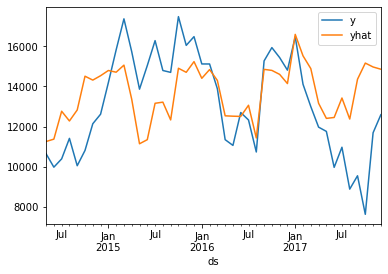

In [48]:
pd.concat([ABC_df_Pesticides_FBP.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

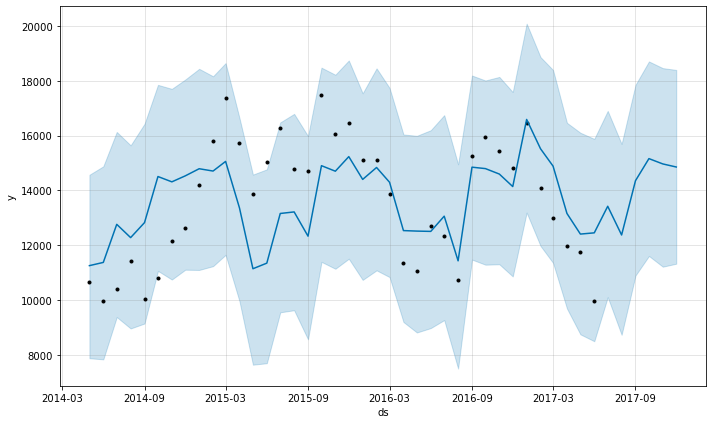

In [49]:
fig1 = m.plot(forecast)

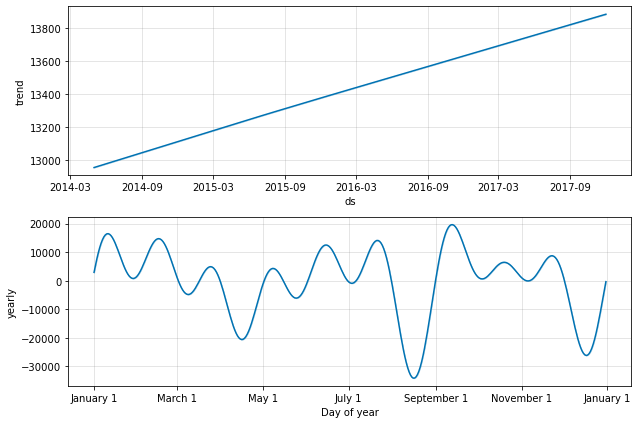

In [50]:
fig2 = m.plot_components(forecast)

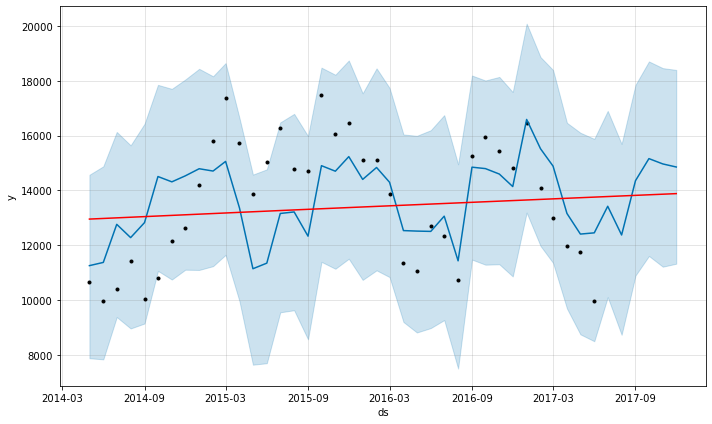

In [51]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [52]:
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [53]:
#check for cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '120 days')
cv_results

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-06-06 00:00:00 and 2017-02-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


ds          yhat    yhat_lower    yhat_upper          y     cutoff
0  2016-07-01  23543.165836  21529.987154  25820.174387  12327.174 2016-06-06
1  2016-08-01  25977.321020  23904.808454  28119.985911  10734.525 2016-06-06
2  2016-09-01  18587.220259  16554.778034  20805.727181  15266.799 2016-06-06
3  2016-10-01  11404.639007   9307.394491  13401.979403  15930.027 2016-06-06
4  2016-09-01  24358.904663  21508.095801  27362.797894  15266.799 2016-08-05
5  2016-10-01  13976.638676  10979.635247  17379.576607  15930.027 2016-08-05
6  2016-11-01  13889.648260  10869.885084  16847.857737  15431.985 2016-08-05
7  2016-12-01  10421.122436   7482.063592  13504.327568  14806.746 2016-08-05
8  2016-11-01  15901.343029  12617.477952  19076.500908  15431.985 2016-10-04
9  2016-12-01  10727.147494   7344.125733  13831.959603  14806.746 2016-10-04
10 2017-01-01  16082.445136  12799.011819  19426.195297  16465.167 2016-10-04
11 2017-02-01  24347.652557  21051.077171  27759.323691  14105.358 2016-10-04
12 2017-01-01  14383.605362  11063.137844  17545.023842  16465.167 2016-12-03
13 2017-02-01  24046.440322  20750.933349  27197.767104  14105.358 2016-12-03
14 2017-03-01  16769.888843  13599.490328  19917.072470  12993.138 2016-12-03
15 2017-04-01  14804.678643  11869.450598  17810.248274  11971.080 2016-12-03
16 2017-03-01  16675.157612  13500.277663  20342.004578  12993.138 2017-02-01
17 2017-04-01  14535.138039  11121.721555  17825.425001  11971.080 2017-02-01
18 2017-05-01  13606.469676  10476.092887  17054.960519  11759.049 2017-02-01
19 2017-06-01  14459.519540  11065.469247  17869.673211   9969.651 2017-02-01

In [54]:
#Check performance metrics
df_p = performance_metrics(cv_results)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   27 days  1.042324e+08  10209.428442  10154.048749  0.752703  0.752703   
1   28 days  6.888783e+06   2624.649061   2075.688821  0.156898  0.156898   
2   29 days  5.610841e+06   2368.721337   2078.625229  0.141660  0.078418   
3   56 days  1.183379e+08  10878.320857   8662.178829  0.773200  0.773200   
4   57 days  1.180793e+08  10866.428954   8598.092172  0.771301  0.771301   
5   58 days  1.022942e+07   3198.347222   3016.493415  0.199073  0.199073   
6   59 days  1.160876e+07   3407.162867   3321.828273  0.244855  0.244855   
7   60 days  5.269976e+07   7259.459738   6252.570181  0.459481  0.459481   
8   87 days  5.492516e+07   7411.150891   6630.751790  0.461133  0.461133   
9   88 days  8.321325e+06   2884.670653   2659.543792  0.195308  0.195308   
10  89 days  1.779720e+06   1334.061314   1115.071270  0.090175  0.090175   
11 117 days  1.112943e+07   3336.079741   2820.229632  0.187127  0.153662   
12 118 days  1.985642e+07   4456.053777   4455.505779  0.290135  0.290135   
13 119 days  1.363149e+07   3692.084459   3609.611103  0.266447  0.266447   
14 120 days  6.253176e+07   7907.702489   7366.081549  0.588241  0.588241   

    coverage  
0       0.00  
1       0.50  
2       0.75  
3       0.50  
4       0.50  
5       0.50  
6       0.50  
7       0.50  
8       0.00  
9       0.50  
10      1.00  
11      0.50  
12      0.00  
13      0.50  
14      0.00

In [55]:
forecast_FBP = forecast.loc[forecast['ds'] > pd.to_datetime(train_end_date)]
forecast_FBP.rename(columns={ 'ds' : 'MONTH'},inplace = True)
forecast_FBP['MONTH'] = pd.to_datetime(forecast_FBP['MONTH'])
forecast_FBP.set_index('MONTH', inplace=True)
forecast_FBP.drop(columns =['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper'], axis = 1, inplace = True)

In [56]:
forecast_FBP

yhat
MONTH                   
2017-07-01  13421.033210
2017-08-01  12374.035317
2017-09-01  14354.518305
2017-10-01  15159.136781
2017-11-01  14965.240598
2017-12-01  14853.026070

In [57]:
ABC_df_Pesticides_FBP_residue = ABC_df_Pesticides_FBP.loc[forecast['ds'] > pd.to_datetime(train_end_date)]

ABC_df_Pesticides_FBP_residue.rename(columns={ 'ds' : 'MONTH', 'y' : 'VALUE'},inplace = True)
ABC_df_Pesticides_FBP_residue.set_index('MONTH', inplace=True)

In [58]:
residual_FBP = ABC_df_Pesticides_FBP_residue['VALUE'] - forecast_FBP['yhat']
residual_FBP

MONTH
2017-07-01   -2450.429210
2017-08-01   -3487.768317
2017-09-01   -4804.375305
2017-10-01   -7526.965781
2017-11-01   -3274.483598
2017-12-01   -2263.493070
dtype: float64

In [59]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual_FBP**2)))

Root Mean Squared Error: 4354.155310466536


In [60]:
print(mean_absolute_error(test.loc[pd.to_datetime(test_start_date)] ,forecast_FBP.loc[pd.to_datetime(test_start_date)]))

2450.4292103068856


In [61]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_FBP.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

42.75033677205704

# Auto Arima

In [62]:
ABC_df_Pesticides_AA = ABC_df_Pesticides.copy(deep=True)

In [63]:
model = pm.auto_arima(ABC_df_Pesticides_AA['VALUE'], m = predict_periods,seasonal= True,start_P= 0,start_q= 0,max_order= 4,test = 'adf',
                     error_action= 'ignore',suppress_warnings= True,stepwise= True,trace= True)

Performing stepwise search to minimize aic
 ARIMA(2,2,0)(0,0,1)[6]             : AIC=761.969, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[6]             : AIC=776.674, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[6]             : AIC=767.489, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[6]             : AIC=755.201, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[6]             : AIC=753.302, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[6]             : AIC=755.220, Time=0.05 sec
 ARIMA(0,2,1)(1,0,1)[6]             : AIC=756.705, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[6]             : AIC=755.236, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[6]             : AIC=755.222, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[6]             : AIC=765.987, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[6]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[6] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[6]          
Total fit time: 0.822 seconds


In [64]:
#Model suumary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   44
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -374.651
Date:                Thu, 24 Jun 2021   AIC                            753.302
Time:                        15:18:23   BIC                            756.778
Sample:                             0   HQIC                           754.576
                                 - 44                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9030      0.092     -9.837      0.000      -1.083      -0.723
sigma2       3.07e+06   7.89e+05      3.891      0.000    1.52e+06    4.62e+06
===================================================================================
Ljung-Box (Q):                       43.36   Jarque-Bera (JB):                 7.94
Prob(Q):                              0.33   Prob(JB):                         0.02
Heteroskedasticity (H):               1.21   Skew:                             0.92
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
ABC_df_Pesticides_AA

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [66]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_AA.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_AA[(ABC_df_Pesticides_AA.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [67]:
train

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651

In [68]:
test

VALUE
MONTH                
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [69]:
#Fitting the model in the train set
model.fit(train['VALUE'])

ARIMA(order=(0, 2, 1), scoring_args={}, seasonal_order=(0, 0, 0, 6),
      suppress_warnings=True, with_intercept=False)

In [70]:
#Forecasting the train model and comparing the value
forecast = model.predict(n_periods=predict_periods,return_conf_int=True)

In [71]:
#Printing the forecast values in the test set
forecast

(array([9449.89292985, 8930.1348597 , 8410.37678955, 7890.6187194 ,
        7370.86064925, 6851.1025791 ]),
 array([[ 6199.76082325, 12700.02503645],
        [ 3988.19134536, 13872.07837404],
        [ 1927.69094594, 14893.06263316],
        [  -97.96461155, 15879.20205035],
        [-2128.95114605, 16870.67244455],
        [-4183.34222161, 17885.54737981]]))

In [72]:
#Resttin the forecast df to and creating the column name for prediction
forecast_df=pd.DataFrame(forecast[0],index= test.index,columns=['Prediction'])

In [73]:
#Printing the dataframe for forecast_dfABC_df
forecast_df

Prediction
MONTH                  
2017-07-01  9449.892930
2017-08-01  8930.134860
2017-09-01  8410.376790
2017-10-01  7890.618719
2017-11-01  7370.860649
2017-12-01  6851.102579

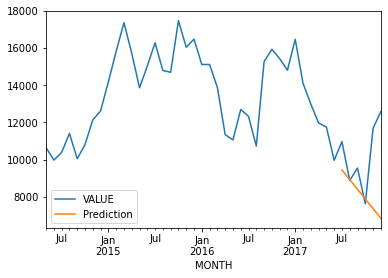

In [74]:
#Conactenating the observed and forecast model and plotting the graph
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast_df],axis=1).plot()

In [75]:
forecast1 = model.predict(n_periods=predict_periods,return_conf_int=True)
forecast1

(array([9449.89292985, 8930.1348597 , 8410.37678955, 7890.6187194 ,
        7370.86064925, 6851.1025791 ]),
 array([[ 6199.76082325, 12700.02503645],
        [ 3988.19134536, 13872.07837404],
        [ 1927.69094594, 14893.06263316],
        [  -97.96461155, 15879.20205035],
        [-2128.95114605, 16870.67244455],
        [-4183.34222161, 17885.54737981]]))

In [76]:
forecast_range=pd.date_range(start= pd.to_datetime(test_start_date) ,periods= predict_periods,freq='MS')
forecast_range

DatetimeIndex(['2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [77]:
forecast1_df = pd.DataFrame(forecast1[0],index= forecast_range,columns=['Prediction'])

In [78]:
forecast1_df

Prediction
2017-07-01  9449.892930
2017-08-01  8930.134860
2017-09-01  8410.376790
2017-10-01  7890.618719
2017-11-01  7370.860649
2017-12-01  6851.102579

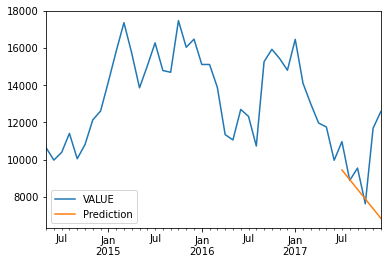

In [79]:
pd.concat([ABC_df_Pesticides_AA['VALUE'],forecast1_df],axis=1).plot()

In [80]:
lower = pd.Series(forecast1[1][:,0],index=forecast_range)
upper = pd.Series(forecast1[1][:,1],index=forecast_range)

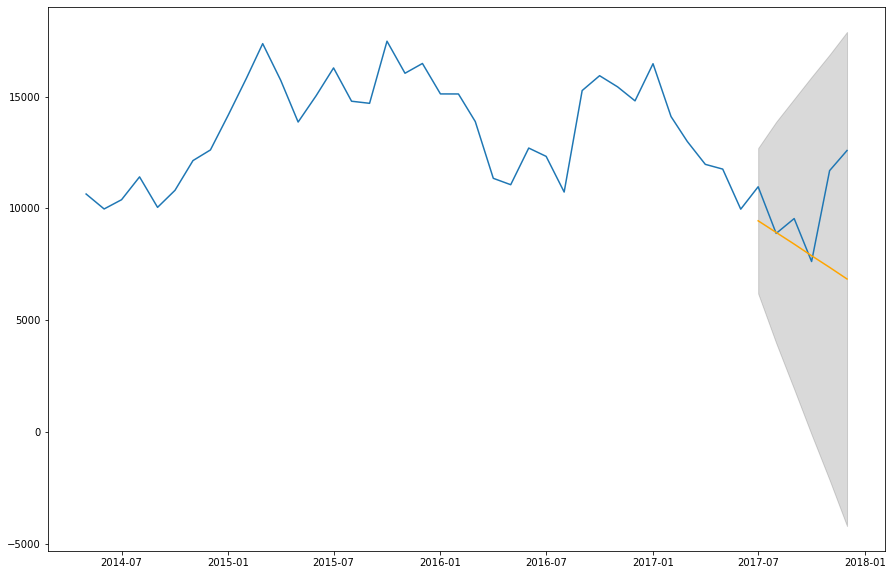

In [81]:
plt.figure(figsize=(15,10))
plt.plot(ABC_df_Pesticides_AA['VALUE'])
plt.plot(forecast1_df,color = 'orange')
plt.fill_between(forecast_range,lower,upper,color = 'k',alpha = .15)


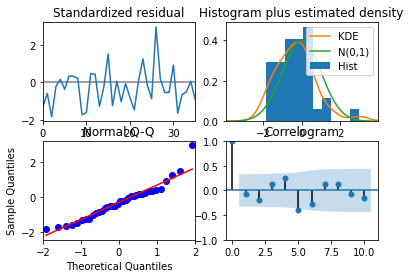

In [82]:
out = model.plot_diagnostics()

In [83]:
residuals_AA = test['VALUE'] - forecast_df['Prediction']
residuals_AA

MONTH
2017-07-01    1520.711070
2017-08-01     -43.867860
2017-09-01    1139.766210
2017-10-01    -258.447719
2017-11-01    4319.896351
2017-12-01    5738.430421
dtype: float64

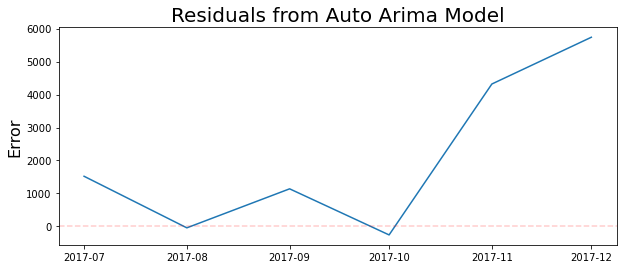

In [84]:
plt.figure(figsize=(10,4))
plt.plot(residuals_AA)
plt.title('Residuals from Auto Arima Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

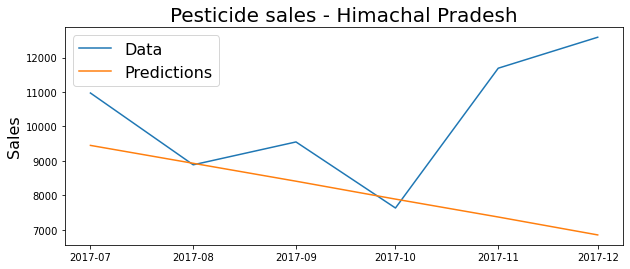

In [85]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(forecast_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Himachal Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [86]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_AA**2)))

Root Mean Squared Error: 3035.1122154673917


In [87]:
print(mean_absolute_error(test['VALUE'] ,forecast_df['Prediction']))

2170.1866052250566


In [88]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = forecast_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

18.701422364678645

# ARMA model

In [89]:
ABC_df_Pesticides_ARMA = ABC_df_Pesticides.copy(deep=True)

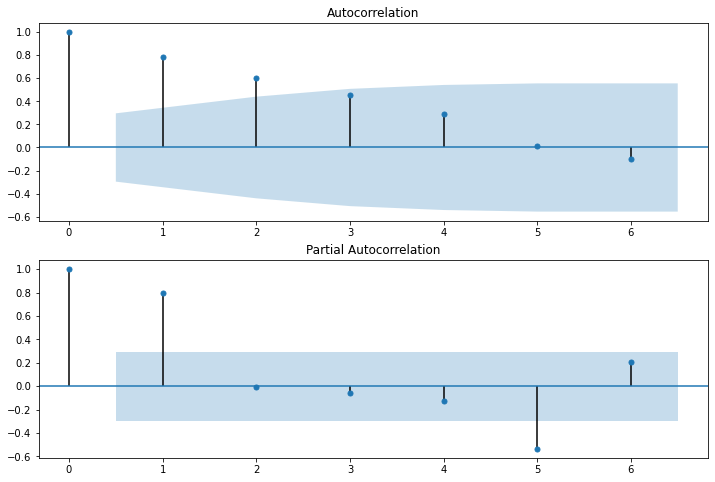

In [90]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax1)
ax2=fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(ABC_df_Pesticides_ARMA,lags=predict_periods,ax = ax2)

In [91]:
train = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_ARMA.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_ARMA[(ABC_df_Pesticides_ARMA.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [92]:
train

VALUE
MONTH                
2014-05-01  10646.451
2014-06-01   9978.795
2014-07-01  10391.814
2014-08-01  11411.631
2014-09-01  10050.750
2014-10-01  10811.421
2014-11-01  12139.929
2014-12-01  12614.751
2015-01-01  14186.826
2015-02-01  15817.410
2015-03-01  17361.459
2015-04-01  15725.637
2015-05-01  13860.369
2015-06-01  15035.625
2015-07-01  16277.301
2015-08-01  14789.979
2015-09-01  14696.775
2015-10-01  17470.485
2015-11-01  16039.350
2015-12-01  16475.859
2016-01-01  15116.139
2016-02-01  15114.276
2016-03-01  13881.402
2016-04-01  11347.587
2016-05-01  11061.765
2016-06-01  12698.910
2016-07-01  12327.174
2016-08-01  10734.525
2016-09-01  15266.799
2016-10-01  15930.027
2016-11-01  15431.985
2016-12-01  14806.746
2017-01-01  16465.167
2017-02-01  14105.358
2017-03-01  12993.138
2017-04-01  11971.080
2017-05-01  11759.049
2017-06-01   9969.651

In [93]:
# define model
model = ARMA(train, order=(1,1))

In [94]:
model_fit = model.fit()

In [95]:
#summary of the model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  VALUE   No. Observations:                   38
Model:                     ARMA(1, 1)   Log Likelihood                -330.712
Method:                       css-mle   S.D. of innovations           1438.035
Date:                Thu, 24 Jun 2021   AIC                            669.425
Time:                        15:18:27   BIC                            675.975
Sample:                    05-01-2014   HQIC                           671.755
                         - 06-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.315e+04    976.823     13.464      0.000    1.12e+04    1.51e+04
ar.L1.VALUE     0.7375      0.162      4.545      0.000       0.419       1.056
ma.L1.VALUE     0.1311      0.260      0.503    

In [96]:
test

VALUE
MONTH                
2017-07-01  10970.604
2017-08-01   8886.267
2017-09-01   9550.143
2017-10-01   7632.171
2017-11-01  11690.757
2017-12-01  12589.533

In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2017-07-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VALUE   6 non-null      float64
dtypes: float64(1)
memory usage: 96.0 bytes


In [98]:
#get the predictions and residuals
predictions = model_fit.predict(start=pd.to_datetime(test_start_date), end = pd.to_datetime(test_end_date))

In [99]:
predictions

2017-07-01    10529.407228
2017-08-01    11217.977408
2017-09-01    11725.776686
2017-10-01    12100.262997
2017-11-01    12376.435104
2017-12-01    12580.103519
Freq: MS, dtype: float64

In [100]:
Pred_range=pd.date_range(start = pd.to_datetime(test_end_date),periods= predict_periods,freq='MS')
Pred_range

DatetimeIndex(['2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [101]:
Pred_df = predictions.to_frame()
Pred_df.info()
Pred_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6 entries, 2017-07-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6 non-null      float64
dtypes: float64(1)
memory usage: 96.0 bytes


0
2017-07-01  10529.407228
2017-08-01  11217.977408
2017-09-01  11725.776686
2017-10-01  12100.262997
2017-11-01  12376.435104
2017-12-01  12580.103519

In [102]:
Pred_df.columns = ['PRED_VALUE']

In [103]:
residuals_ARMA = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_ARMA

MONTH
2017-07-01     441.196772
2017-08-01   -2331.710408
2017-09-01   -2175.633686
2017-10-01   -4468.091997
2017-11-01    -685.678104
2017-12-01       9.429481
dtype: float64

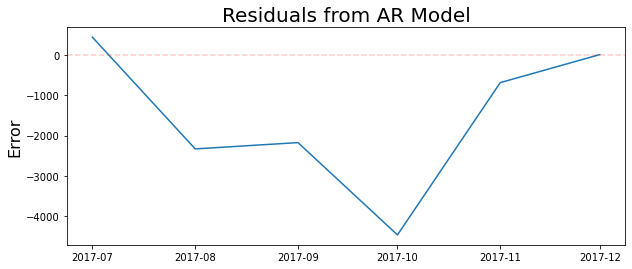

In [104]:
plt.figure(figsize=(10,4))
plt.plot(residuals_ARMA)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

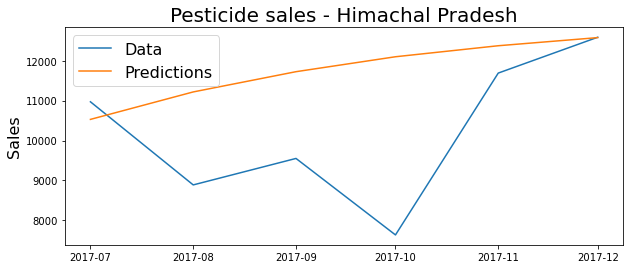

In [105]:
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(Pred_df)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pesticide sales - Himachal Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [106]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_ARMA**2)))

Root Mean Squared Error: 2265.649260271419


In [107]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1685.2900747393653


In [108]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

19.58752871552375

# SARIMAX Model

In [109]:
ABC_df_Pesticides_SARIMAX = ABC_df_Pesticides.copy(deep=True)

In [110]:
p = range(0, 3)
d = range(0, 1)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[0], x[0], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
               
            continue            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
SARIMAX: (0, 0, 2) x (1, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:941.4577936258693
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:941.4577936258693
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:941.4577936258693
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:359.15627771781175
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:359.15627771781175
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:359.15627771781175
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:10.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.856173973752
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.856173973752
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:872.856173973752
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:338.24555955678886
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:338.24555955678886
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:338.24555955678886
ARIMA(0, 0, 1)

In [111]:
# Fitting the data to SARIMA model 
model = sm.tsa.statespace.SARIMAX(ABC_df_Pesticides_SARIMAX['VALUE'], 
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 2, 12),  
                                continueenforce_invertibility=False)

In [112]:
results = model.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8168   4231.782      0.000      1.000   -8293.323    8294.957
ar.S.L24      -0.6691   1.23e+04  -5.42e-05      1.000   -2.42e+04    2.42e+04
ma.S.L12      -1.2742   1503.137     -0.001      0.999   -2947.369    2944.821
ma.S.L24       0.6363   1.97e+04   3.22e-05      1.000   -3.87e+04    3.87e+04
sigma2      1.739e+07     16.241   1.07e+06      0.000    1.74e+07    1.74e+07


In [113]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         VALUE   No. Observations:                   44
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                -195.318
Date:                       Thu, 24 Jun 2021   AIC                            400.635
Time:                               15:18:46   BIC                            405.614
Sample:                           05-01-2014   HQIC                           401.607
                                - 12-01-2017                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8168   4231.782      0.000      1.000   -8293.323    8294.957
ar.S.L24      -0.6691   1.23e+04  -5.42e-05      1.000   -2.42e+04    2.42e+04
ma.S.L12      -1.2742   1503.137     -0.001      0.999   -2947.369    2944.821
ma.S.L24       0.6363   1.97e+04   3.22e-05      1.000   -3.87e+04    3.87e+04
sigma2      1.739e+07     16.241   1.07e+06      0.000    1.74e+07    1.74e+07
===================================================================================
Ljung-Box (Q):                       53.72   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.00   Prob(JB):                         0.63
Heteroskedasticity (H):               0.94   Skew:                             0.37
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.32e+21. Standard errors may be unstable.
"""

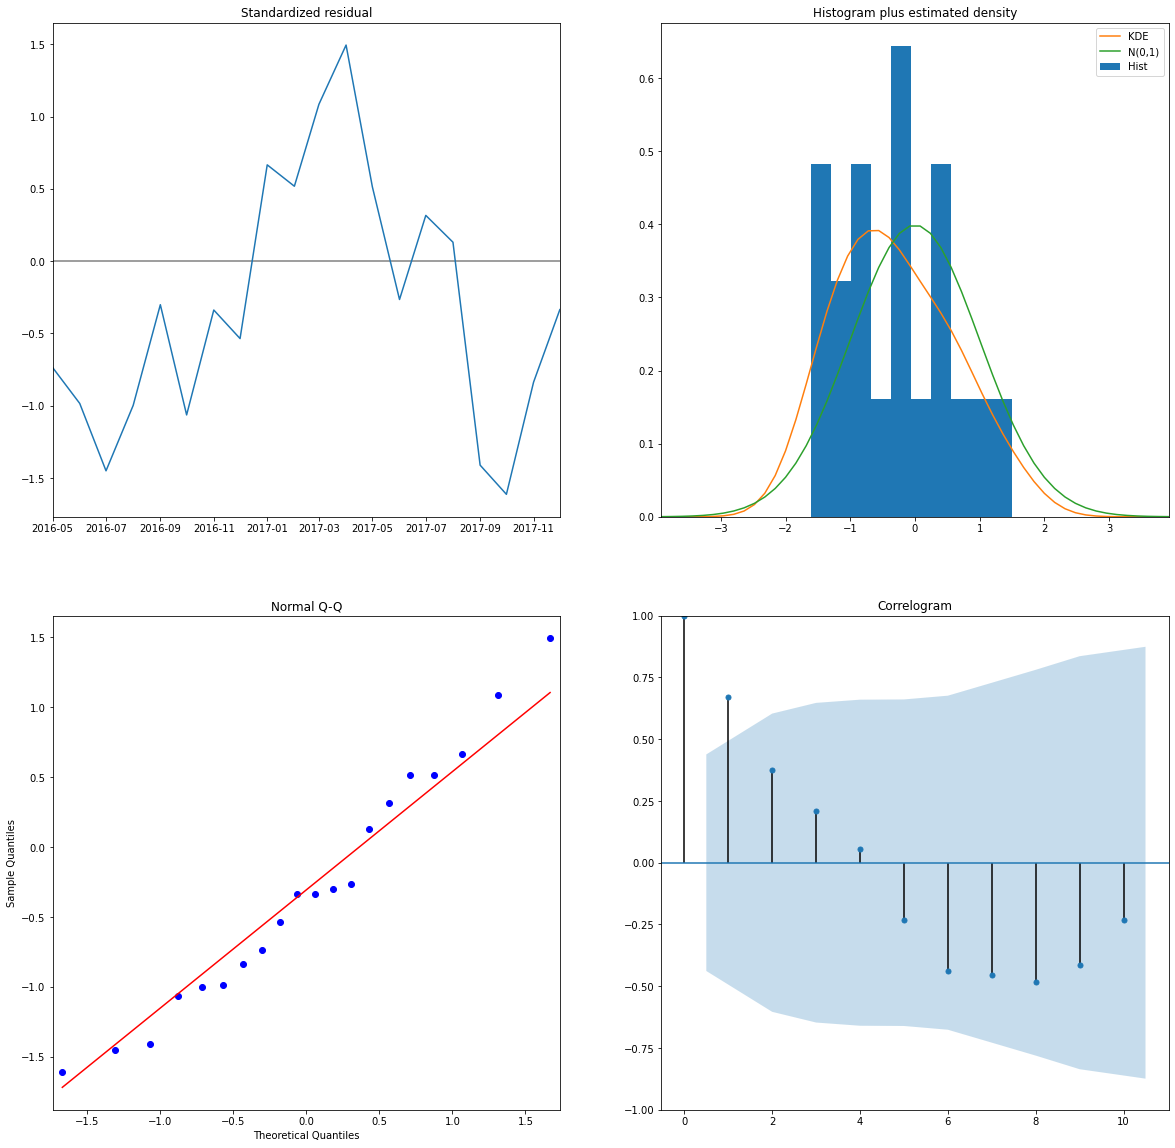

In [114]:
# Checking diagnostic plots
results.plot_diagnostics(figsize=(20, 20))
plt.show()

In [115]:
train = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) >= pd.to_datetime(train_start_date)) &
                               (ABC_df_Pesticides_SARIMAX.index.get_level_values(0) <= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_SARIMAX[(ABC_df_Pesticides_SARIMAX.index.get_level_values(0) > pd.to_datetime(train_end_date))]

In [116]:
forecast = results.predict(12)
forecast

2015-05-01    19720.473960
2015-06-01    18483.771442
2015-07-01    19248.808583
2015-08-01    21137.820667
2015-09-01    18617.054045
2015-10-01    20026.048709
2015-11-01    22486.850662
2015-12-01    23366.365807
2016-01-01    26278.328122
2016-02-01    29298.666947
2016-03-01    32158.716564
2016-04-01    29128.675364
2016-05-01    14572.497803
2016-06-01    17397.602812
2016-07-01    19250.380422
2016-08-01    15498.122843
2016-09-01    16705.075586
2016-10-01    21007.806493
2016-11-01    17045.865698
2016-12-01    17363.577676
2017-01-01    13285.717893
2017-02-01    11631.925801
2017-03-01     7814.411896
2017-04-01     4836.186124
2017-05-01     9477.682170
2017-06-01    11146.666431
2017-07-01     9566.733663
2017-08-01     8305.612258
2017-09-01    15810.515246
2017-10-01    14787.982156
2017-11-01    15405.331886
2017-12-01    14076.784889
Freq: MS, dtype: float64

In [117]:
Predicted_df = pd.DataFrame(forecast.loc[forecast.index.isin(test.index)], columns=["PRED_VALUE"])
Predicted_df

PRED_VALUE
2017-07-01   9566.733663
2017-08-01   8305.612258
2017-09-01  15810.515246
2017-10-01  14787.982156
2017-11-01  15405.331886
2017-12-01  14076.784889

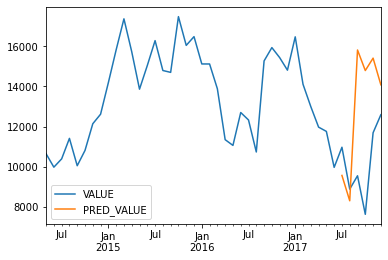

In [118]:
pd.concat([ABC_df_Pesticides_SARIMAX['VALUE'], Predicted_df], axis=1).plot()

In [119]:
residuals_SARIMAX = test['VALUE'] - Pred_df['PRED_VALUE']
residuals_SARIMAX

MONTH
2017-07-01     441.196772
2017-08-01   -2331.710408
2017-09-01   -2175.633686
2017-10-01   -4468.091997
2017-11-01    -685.678104
2017-12-01       9.429481
dtype: float64

In [120]:
#get the predictions

predict_future = results.forecast(len(test))
predict_future

2018-01-01    18352.385045
2018-02-01    14676.821361
2018-03-01    14129.167261
2018-04-01    14161.474411
2018-05-01    14861.588649
2018-06-01    11015.519256
Freq: MS, dtype: float64

In [121]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_SARIMAX**2)))

Root Mean Squared Error: 2265.649260271419


In [122]:
print(mean_absolute_error(test['VALUE'] ,Pred_df['PRED_VALUE']))

1685.2900747393653


In [123]:
#Calculate MAPE%
y_true = test.loc[pd.to_datetime(test_start_date):].values
y_pred = Pred_df.loc[pd.to_datetime(test_start_date):].values

p_mean_absolute_percentage_error(y_true, y_pred)

19.58752871552375

# Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [139]:
ABC_df_Pesticides_hwm =  ABC_df_Pesticides.copy(deep=True)

In [140]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [141]:
#Splitting the data into training and testing set
train = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)>= pd.to_datetime(train_start_date) ) &
                               (ABC_df_Pesticides_hwm.index.get_level_values(0)<= pd.to_datetime(train_end_date))]
test = ABC_df_Pesticides_hwm[(ABC_df_Pesticides_hwm.index.get_level_values(0)> pd.to_datetime(train_end_date))]

In [142]:
pred1 = ExponentialSmoothing(np.asarray(train['VALUE']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit() #[:'2017-01-01']
print('')
print('== Holt-Winters Additive ETS(A,A,A) Parameters ==')
print('')
alpha_value = np.round(pred1.params['smoothing_level'], 4)
print('Smoothing Level: ', alpha_value)
print('Smoothing Slope: ', np.round(pred1.params['smoothing_slope'], 4))
print('Smoothing Seasonal: ', np.round(pred1.params['smoothing_seasonal'], 4))
print('Initial Level: ', np.round(pred1.params['initial_level'], 4))
print('Initial Slope: ', np.round(pred1.params['initial_slope'], 4))
print('Initial Seasons: ', np.round(pred1.params['initial_seasons'], 4))
print('')

### Forecast for next 6 months

y_pred1 =  pred1.forecast(steps = 6)
df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['VALUE']})
print(df_pred1)


== Holt-Winters Additive ETS(A,A,A) Parameters ==

Smoothing Level:  0.7368
Smoothing Slope:  0.0334
Smoothing Seasonal:  0.2632
Initial Level:  1.0808
Initial Slope:  0.0128
Initial Seasons:  [ 0.1648  0.0697 -0.0685 -0.2882  0.0875  0.2133  0.0616  0.2223  0.2729
  0.1623  0.066  -0.1505]

               Y_hat         Y
MONTH                         
2017-07-01  1.027383  1.097060
2017-08-01  0.822537  0.888627
2017-09-01  1.002860  0.955014
2017-10-01  1.125445  0.763217
2017-11-01  1.066701  1.169076
2017-12-01  1.110986  1.258953


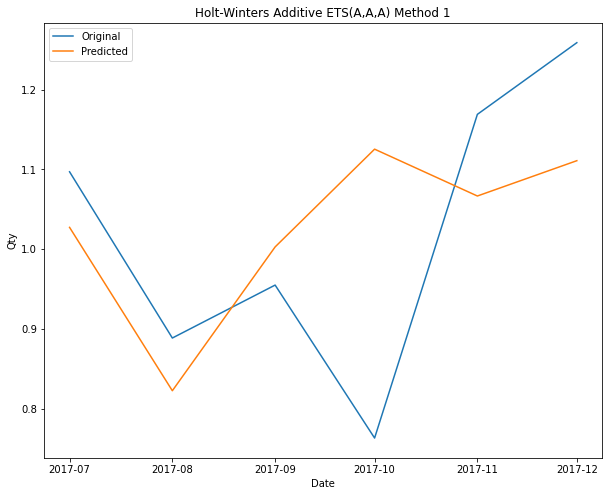

In [143]:
### Plot

fig2, ax = plt.subplots()
ax.plot(df_pred1.Y, label='Original')
ax.plot(df_pred1.Y_hat, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [144]:
residuals_hwm = df_pred1.Y - df_pred1.Y_hat
residuals_hwm


MONTH
2017-07-01    0.069677
2017-08-01    0.066090
2017-09-01   -0.047846
2017-10-01   -0.362228
2017-11-01    0.102375
2017-12-01    0.147968
dtype: float64

In [145]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_hwm**2)))

Root Mean Squared Error: 0.17082929016265785


In [146]:
print(mean_absolute_error(df_pred1.Y, df_pred1.Y_hat))

0.13269718427178545


In [147]:

mape    =  p_mean_absolute_percentage_error(df_pred1.Y, df_pred1.Y_hat)

print("For alpha = %1.2f,  MAPE is %3.2f" %(alpha_value, mape))

For alpha = 0.74,  MAPE is 14.46


In [148]:
#Future forecast
final_model = ExponentialSmoothing(ABC_df_Pesticides_hwm['VALUE'], trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 12).fit()

In [149]:
pred=final_model.forecast(12)
pred

2018-01-01    1.370801
2018-02-01    1.386705
2018-03-01    1.432935
2018-04-01    1.286986
2018-05-01    1.182088
2018-06-01    1.128884
2018-07-01    1.138391
2018-08-01    0.955291
2018-09-01    1.067267
2018-10-01    1.088853
2018-11-01    1.230269
2018-12-01    1.233816
Freq: MS, dtype: float64

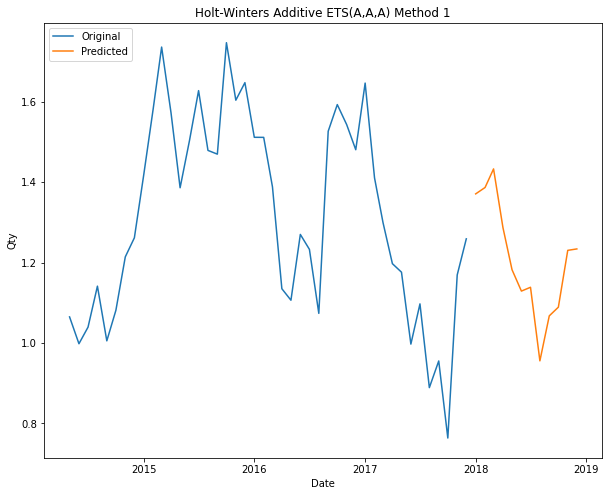

In [150]:
### Plot

fig2, ax = plt.subplots()
ax.plot(ABC_df_Pesticides_hwm['VALUE'], label='Original')
ax.plot(pred, label='Predicted')

plt.legend(loc='upper left')
plt.title('Holt-Winters Additive ETS(A,A,A) Method 1')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

# To check if Rainfall has any effect on Insecticides sales

In [151]:
Rainfall = [12.9,16.7,26.5,7.5, 20,25.8,71,33.5,67,10.8,0.2,9.4,12.1,6.6,70.7,34.9,8.3,43.5,127.9,84.4,32,3.8,2.3,0.2,
            0,1.1,20.7,0.6,26.8,34.8,155.1,133.8,13.7,5.2,0,0.9,33.8,0.3,7.2,3.7,10.1,121.8,67.7,74.7,91.8,0,1.8,4.2]

In [152]:
ABC_df_Pesticides['Rainfall'] = Rainfall[rolling_period - 1:]

Text(0, 0.5, 'Sales')

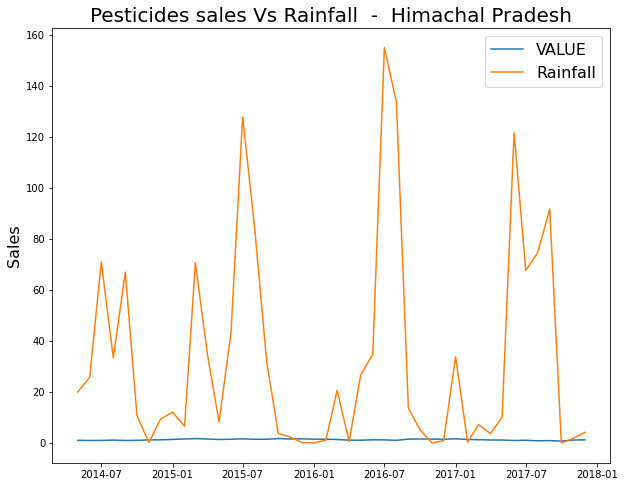

In [153]:
plt.plot(ABC_df_Pesticides)

plt.legend(('VALUE', 'Rainfall'), fontsize=16)

plt.title('Pesticides sales Vs Rainfall  -  Himachal Pradesh', fontsize=20)
plt.ylabel('Sales', fontsize=16)

#Feature scaling for 'VALUE' column as Rainfall column

In [154]:
#Taking Rainfall and Value column on a common scale
ABC_df_Pesticides['VALUE'] = ABC_df_Pesticides['VALUE']/10000

In [155]:
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000230D548ADC0>,
      dtype=object)

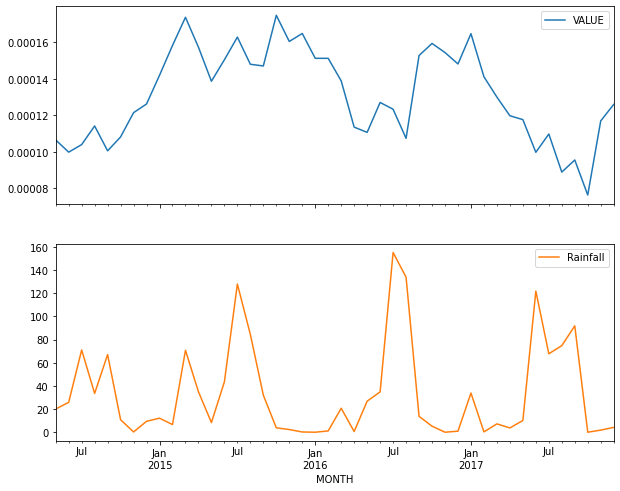

In [156]:
ABC_df_Pesticides.plot(subplots=True)

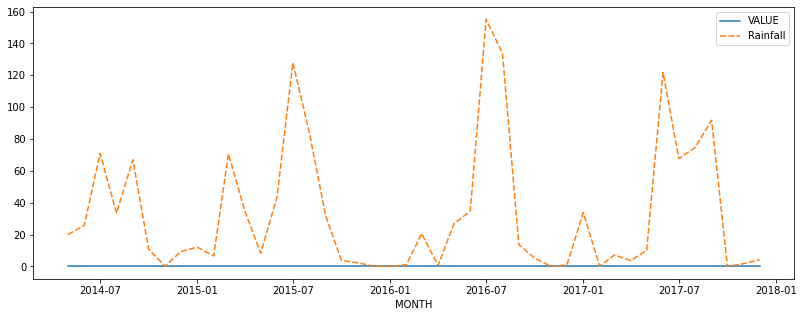

In [157]:
plt.figure(figsize = (30,5))
plt.subplot(1,2,1)
sns.lineplot(data=ABC_df_Pesticides)

In [158]:
#to find the coorelation betwween Rainfall and Value

In [159]:
col1 = ABC_df_Pesticides["Rainfall"]
col2 = ABC_df_Pesticides["VALUE"]

In [160]:
correlation = col1.corr(col2)
correlation

-0.23316400228697756

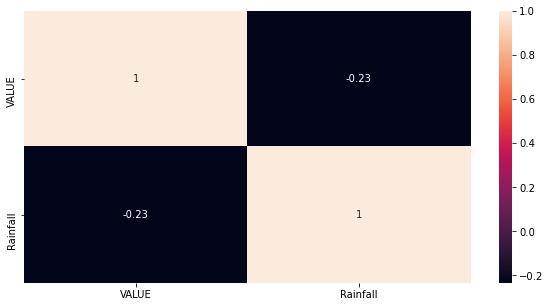

In [161]:
plt.figure(figsize = (10,5))
sns.heatmap(ABC_df_Pesticides.corr(),annot = True)